In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/Searched Ranking/")
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/Searched Ranking'

In [2]:
!pip install pandas
!pip install sentence_transformers
!pip install faiss-gpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 54.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 82.7 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=16163ef6a7583386a21196ce13cfbe87a351e09838aceaad2f7d790f3c833b91
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 9.3 MB/s eta 0:00:00


In [3]:
import pandas as pd

# Used to create the dense document vectors.
import torch
from torch.quantization import quantize_dynamic
import sentence_transformers
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
from pathlib import Path

import time

print(torch.__version__)
print(pd.__version__)
print(sentence_transformers.__version__)
print(faiss.__version__)
print(np.__version__)

2.0.1+cu118
1.5.3
2.2.2
1.7.2
1.23.5


In [4]:
# Read a CSV in a table
df_ = pd.read_csv('data/data_curated.csv')

df_.head()

,Unnamed: 0,title,abstract,index
0,0,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...,0
1,1,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...,1
2,2,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...,2
3,3,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...,3
4,4,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...,4


In [9]:
df = df_.iloc[:100000, :]

In [6]:
# we will use the distilbert-base-nli-stsb-mean-tokens model which has the best performance on Semantic
# Textual Similarity tasks among the DistilBERT versions

model = SentenceTransformer('paraphrase-MiniLM-L3-v2', device="cpu")

In [7]:
# Quantization of the transformer

q_model = quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

In [10]:
# Convert abstracts to vectors

start_time = time.time()
embeddings = model.encode(df.title.to_list(), show_progress_bar=True)
diff_normal = time.time() - start_time
print("Done after {:.2f}".format(diff_normal))

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Done after 785.61


In [11]:
start_time = time.time()
q_embeddings = q_model.encode(df.title.to_list(), show_progress_bar=True)
diff_quantized = time.time() - start_time
print("Done after {:.2f}".format(diff_quantized))

Batches:   0%|          | 0/3125 [00:00<?, ?it/s]

Done after 591.46


In [12]:
print(embeddings.shape, q_embeddings.shape)

(100000, 384) (100000, 384)


In [13]:
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (MB):', size/1e6)
    os.remove('temp.p')
    return size

In [14]:
f=print_size_of_model(model,"model_cpu")
q=print_size_of_model(q_model,"model_int8")
print("{0:.2f} times smaller".format(f/q))

model:  model_cpu  	 Size (MB): 69.577877
model:  model_int8  	 Size (MB): 53.225457
1.31 times smaller


In [15]:
from numpy import dot
from numpy.linalg import norm

def cosine_func(emb1, emb2):
  return dot(emb1, emb2)/(norm(emb1)*norm(emb2))

results = []
for i in range(embeddings.shape[0]):
  results.append(cosine_func(embeddings[i, :], q_embeddings[i, :]))

In [16]:
len(results)

100000

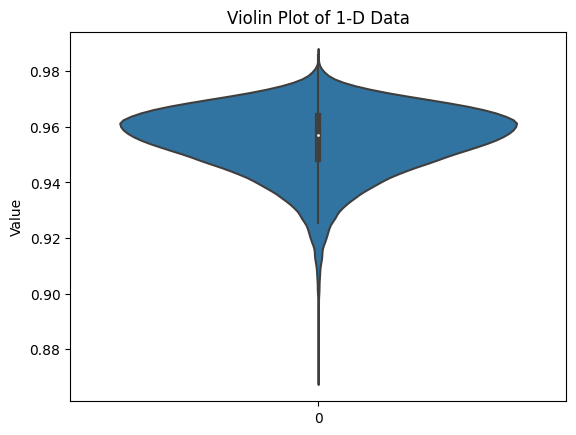

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.violinplot(data=results, orient="v")
plt.ylabel("Value")
plt.title("Violin Plot of 1-D Data")
plt.show()

In [18]:
# Taken from Search model.ipynb

# Step 1: Change data type
embeddings = np.array([embedding for embedding in q_embeddings]).astype("float32")

# Step 2: Instantiate the index
index = faiss.IndexFlatL2(q_embeddings.shape[1])

# Step 3: Pass the index to IndexIDMap
index = faiss.IndexIDMap(index)

# Step 4: Add vectors and their IDs
index.add_with_ids(embeddings, df.index.values[:400000])

print(f"Number of vectors in the Faiss index: {index.ntotal}")

Number of vectors in the Faiss index: 100000


In [19]:
# Searching the index

print(df.loc[555, "title"])
print(df.loc[555, "abstract"])
print()

# Retrieve the 10 nearest neighbours
D, I = index.search(np.array([embeddings[555]]), k=10)
print(f'L2 distance: {D.flatten().tolist()}\n\nMAG paper IDs: {I.flatten().tolist()}')

Gene Expression Profile during Chondrogenesis in Human Bone Marrow derived Mesenchymal Stem Cells using a cDNA Microarray
Mesenchymal stem cells (MSCs) have the capacity to proliferate and differentiate into multiple connective tissue lineages, which include cartilage, bone, and fat. Cartilage differentiation and chondrocyte maturation are required for normal skeletal development, but the intracellular pathways regulating this process remain largely unclear. This study was designed to identify novel genes that might help clarify the molecular mechanisms of chondrogenesis. Chondrogenesis was induced by culturing human bone marrow (BM) derived MSCs in micromass pellets in the presence of defined medium for 3, 7, 14 or 21 days. Several genes regulated during chondrogenesis were then identified by reverse transcriptase-polymerase chain reaction (RT-PCR). Using an ABI microarray system, we determined the differential gene expression profiles of differentiated chondrocytes and BM-MSCs. Norma

In [20]:
def id2details(df, I, column):
    """Returns the paper titles based on the paper index."""
    return [list(df[df.index == idx][column]) for idx in I[0]]

In [21]:
# Fetch the paper titles based on their index
id2details(df, I, 'title')

[['Gene Expression Profile during Chondrogenesis in Human Bone Marrow derived Mesenchymal Stem Cells using a cDNA Microarray'],
 ['Semaphorin3B Promotes Proliferation and Osteogenic Differentiation of Bone Marrow Mesenchymal Stem Cells in a High-Glucose Microenvironment'],
 ['Human Bone Marrow Mesenchymal Stem/Stromal Cells Exposed to an Inflammatory Environment Increase the Expression of ICAM-1 and Release Microvesicles Enriched in This Adhesive Molecule: Analysis of the Participation of TNF-α and IFN-γ'],
 ['Isolation and Cellular Phenotyping of Mesenchymal Stem Cells Derived from Synovial Fluid and Bone Marrow of Minipigs.'],
 ['Efficient isolation and chondrogenic differentiation of adult mesenchymal stem cells with fibrin microbeads and micronized collagen sponges.'],
 ['Mesenchymal Stem Cell–Immune Cell Interaction and Related Modulations for Bone Tissue Engineering'],
 ['Changes in the Transcriptome Profiles of Human Amnion-Derived Mesenchymal Stromal/Stem Cells Induced by Three

In [22]:
# Serialise index and store it as a pickle
with open(f"models/q_faiss_index.pickle", "wb") as h:
    pickle.dump(faiss.serialize_index(index), h)